# **1**. **Dataset Preparation**

> *I started this project by first extracting the dataset. Then I created a smaller dataset by saving the classes requested in the project in a list and again saved the first 650 images from each class as specified in the project. The reason for this is to ensure that the dataset is balanced.*

* **classes:** Variable containing the list of animal species to be classified.

* **directory:** Specifies the folder path where the images are located.

* **max_images_per_class:** Specifies the maximum number of images to be retrieved for each animal class. (650)

* **class_images:** A dictionary used to store the image paths of each animal class.

* **os.walk:** Walks through all files and folders in the specified directory and subdirectories, collects images belonging to the specified classes, and adds a maximum of 650 images for each class to the class_images dictionary.

In [1]:
import os

# List of class names to be classified
classes = ['collie', 'dolphin', 'elephant', 'fox', 'moose', 'rabbit', 'sheep', 'squirrel', 'giant+panda', 'polar+bear']

# Folder path
directory = '/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages'

# Maximum number of images that should be in each folder
max_images_per_class = 650

# A dictionary to store the resulting data set
class_images = {class_name: [] for class_name in classes}

# Checking images in subfolders
for dirname, subdirs, filenames in os.walk(directory):
    class_name = os.path.basename(dirname)
    
    if class_name in classes:
        # Add first 650 images
        for filename in filenames[:max_images_per_class]:
            class_images[class_name].append(os.path.join(dirname, filename))

# Print the first 650 images for each class
for class_name, images in class_images.items():
    print(f"{class_name}: {len(images)} images")


collie: 650 images
dolphin: 650 images
elephant: 650 images
fox: 650 images
moose: 650 images
rabbit: 650 images
sheep: 650 images
squirrel: 650 images
giant+panda: 650 images
polar+bear: 650 images


> *To ensure that the input data for the model is consistent, I created a function that will resize the images to a specific size and normalize them. Then, for each class, I normalized the images using this function.*

In [2]:
import cv2

# Size of image to resize
image_size = (128, 128)

# Function to normalize and resize images
def resize_and_normalize_image(image_path, image_size):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, image_size)
    img_normalized = img_resized / 255.0
    return img_normalized

# Creating a dictionary to normalize images according to classes
normalized_images = {}

for class_name, images in class_images.items():
    normalized_images[class_name] = [resize_and_normalize_image(img_path, image_size) for img_path in images]


> *At this stage, I prepared the data to be used in the training and evaluation stages of the model. I converted the normalized images and their labels to numpy arrays. I used LabelEncoder to convert the labels to numerical values and divided the data into training and test sets. These operations are necessary for the model to learn more efficiently and accurately.*

* **X, y:** Lists containing normalized images and their labels.

* **LabelEncoder:** Converts labels (animal classes) to numerical values.

* **train_test_split:** Splits the data into training (70%) and test (30%) sets, so we can evaluate the performance of the model.

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Convert images and tags to lists
X, y = [], []

for class_name, images in normalized_images.items():
    X.extend(images)
    y.extend([class_name] * len(images))

# Convert list to numpy array
X = np.array(X)
y = np.array(y)

# Converting labels to numeric values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


> *In this step, i used the `ImageDataGenerator` from TensorFlow's Keras module to apply data augmentation techniques to the training images. Data augmentation is a strategy used to artificially increase the size of the training dataset by creating transformed versions of the existing images. This helps the model generalize better by exposing it to a variety of image variations.*

- **rotation_range=30:** Randomly rotates the image by up to 30 degrees.
  
- **width_shift_range=0.3:** Randomly shifts the image horizontally by up to 30% of the total width.
  
- **height_shift_range=0.3:** Randomly shifts the image vertically by up to 30% of the total height.
  
- **shear_range=0.3:** Shears the image by up to 30%, which distorts the image along one axis.
  
- **zoom_range=0.3:** Zooms in or out on the image by up to 30%.
  
- **horizontal_flip=True:** Randomly flips the image horizontally.
  
- **fill_mode='nearest':** When a transformation results in empty pixels, the nearest pixel value is used to fill them.

> *By augmenting the data in this way, i am enchanced the model's ability to recognize patterns in images, regardless of small variations in orientation, position, or scale.*

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Describe data augmentation techniques
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Applying these techniques to training data
datagen.fit(X_train)


# **2. Creating a CNN model**

> *I have described a Convolutional Neural Network (CNN) architecture for image classification. The model is built sequentially, meaning each layer is stacked on top of the previous one.*

### Model Structure:
**1.** **Convolutional Layers (Conv2D):**
- These layers apply convolution operations to the input image, helping the model learn local patterns like edges, textures, and shapes.
- The first convolutional layer has 32 filters of size 3x3 each and uses the ReLU activation function (`activation='relu'`).
- Each subsequent convolutional layer has more filters (64, 128, 256) to capture more complex features.

**2.** **BatchNormalization):**
- This layer normalizes the output of the convolutional layers, ensuring that the activations maintain a consistent scale during training. It helps in faster convergence and stabilizes the training process.

**3.** **MaxPooling2D):**
- These layers perform downsampling on feature maps by reducing the spatial dimensions (width and height) of the data while preserving important features. It helps in reducing computational complexity and preventing overfitting.

**4.** **Flatten Layer:**
- After convolutional and pooling layers, the output is a multidimensional array. The flattening layer converts it into a one-dimensional vector that will be fed to fully connected layers (Dense layers).

**5.** **Fully Connected Layers (Dense):**
- The first dense layer has 512 units and uses the ReLU activation function. This allows the model to learn complex representations based on the features extracted by the convolutional layers.

- The output layer is a dense layer (`len(classes)`) with a number of units equal to the number of classes and uses the `softmax` activation function to output the probabilities for each class.

**6.** **Dropout:**
- Dropout is a regularization technique that randomly drops a portion of neurons (in this case 40%) during training to prevent overfitting. This allows the model to generalize better by not relying on any particular neuron.

### Optimizer:
**Adam Optimizer:**
- Adam is used as the optimizer that adjusts the learning rate during training and is known to converge faster and more efficiently than other optimizers like SGD.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(len(classes), activation='softmax')
])

> *I set early stopping to prevent overfitting and compile the model for training. The `EarlyStopping` callback monitors the validation loss during training and stops the training process early if the model's performance stops improving. This helps to avoid unnecessary epochs that do not contribute to improving the model, thus saving computational resources and preventing overfitting. Before training, the model is compiled. This process involves defining the optimizer, loss function, and evaluation metrics.*

- **optimizer=Adam(learning_rate=0.001):** You are using the Adam optimizer with a learning rate of 0.001. Adam is an adaptive optimizer that adjusts the learning rate during training and is generally suitable for most deep learning tasks.
- **loss='sparse_categorical_crossentropy':** This is the loss function for multi-class classification problems where the labels are integers. It is used when the target values ​​are class indices, not one-hot encoded. - **metrics=['accuracy']:** The performance of the model will be evaluated using accuracy during training.

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5,  # Stop after 5 epochs with no improvement
                               restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,116,618 (19.52 MB)

 Trainable params: 5,114,634 (19.51 MB)

 Non-trainable params: 1,984 (7.75 KB)

> *The `model.fit` method is used to train the model on the provided data. This code initiates the training process while leveraging data augmentation through the `ImageDataGenerator`. The early stopping mechanism ensures the model doesn't overfit and training stops when no significant improvement is observed. The training will run for up to 30 epochs, but may stop earlier based on validation loss.*

# **3. Testing the Model**

In [11]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/30
 77/143 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.2641 - loss: 2.9487 

I0000 00:00:1734804085.735901      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 64 bytes spill stores, 64 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 88 bytes spill stores, 88 bytes spill loads



143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 147ms/step - accuracy: 0.2829 - loss: 2.6917 - val_accuracy: 0.1087 - val_loss: 3.4360
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.3835 - loss: 1.8467 - val_accuracy: 0.1836 - val_loss: 3.0591
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.4391 - loss: 1.6822 - val_accuracy: 0.3656 - val_loss: 2.1098
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - accuracy: 0.4682 - loss: 1.5738 - val_accuracy: 0.3533 - val_loss: 1.8471
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.5132 - loss: 1.4458 - val_accuracy: 0.3862 - val_loss: 1.7505
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.5215 - loss: 1.3496 - val_accuracy: 0.4841 - val_loss: 1.5533
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - accuracy: 0.5718 - loss: 1.2664 - val_accuracy: 0.5667 - val_loss: 1.2589
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.5627 - loss: 1.2358 - val

> *I have visually evaluated the performance of the model during training by plotting the training and validation accuracy and loss of the trained model over epochs.*

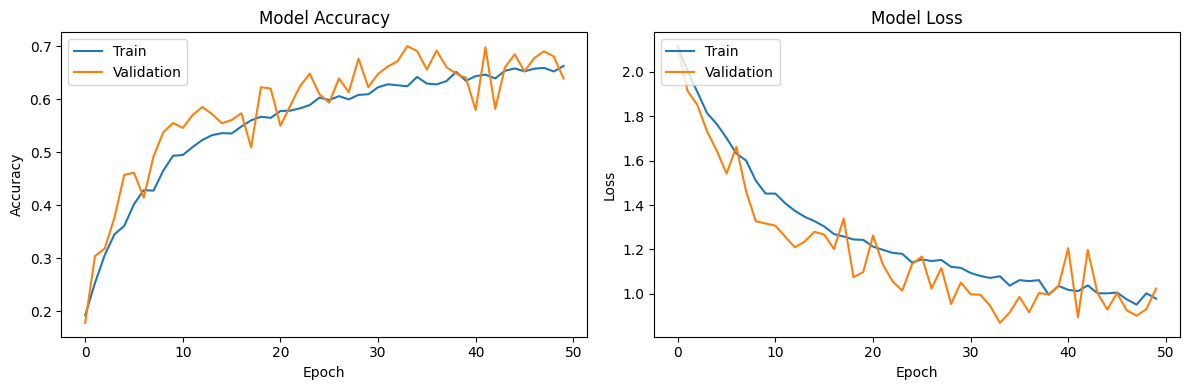

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

* *The model is improving in training accuracy but struggles with validation accuracy. Further adjustments to training strategies, model architecture, or data preprocessing are needed to improve generalization.*

# **4. CNN Model Manipulation**

> *In this code, I defined a function called `get_manipulated_images()` that applies brightness and contrast adjustments to the test data.*

### Function: `get_manipulated_images`
**Parameters:**
- **`images`**: This is the input list of images you want to edit.
- **`alpha`**: This parameter controls the contrast of the image. The default value is `1.5`, which means the contrast is increased.
- **`beta`**: This parameter controls the brightness of the image. The default value is `30`, which means the brightness is added to the image.


### Editing Test Images
- This applies the `get_manipulated_images()` function to the test set (`X_test`) with `alpha=1.2` and `beta=10` as contrast and brightness parameters.
- The edited test images are stored in `X_test_manipulated`.

In [15]:
def get_manipulated_images(images, alpha=1.5, beta=30):
    manipulated_images = []
    for img in images:
        # Adjusting brightness and contrast
        manipulated = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
        manipulated_images.append(manipulated)
    return np.array(manipulated_images)

# Manipulating test images
X_test_manipulated = get_manipulated_images(X_test, alpha=1.2, beta=10)


*This code evaluates the performance of trained model on a manipulated test set.*

*The test accuracy after the model is evaluated on the manipulated images, giving you insight into how the model performs when the input images have been altered in terms of brightness and contrast.*

In [16]:
# Testing the model with a manipulated test set
test_loss, test_accuracy = model.evaluate(X_test_manipulated, y_test)
print(f"Test accuracy with manipulated images: {test_accuracy}")


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1028 - loss: 30.3643
Test accuracy with manipulated images: 0.11179487407207489


* *The results from evaluating the model on the manipulated test set show a significant drop in accuracy, which indicates that the model struggles to generalize well when the input images are altered in terms of brightness and contrast.*

# **4. Applying Color Constancy Algorithm to Manipulated Images**

> This code applies a **color constancy** algorithm to manipulated test set in an effort to improve the images by correcting the color balance. This can help determine if the color constancy correction improves the model's performance by reducing the impact of brightness and contrast manipulations. 

#### **`apply_color_constancy(image)`**:
   - This function applies the **Gray World algorithm** for color constancy. The idea behind this algorithm is that the average color of the world (in natural images) is achromatic (neutral gray), so the algorithm attempts to balance the color channels based on the assumption that the image should have an overall gray appearance.

In [17]:
import cv2
import numpy as np

def apply_color_constancy(image):
    # Gray World algoritması
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_gray = np.mean(img_gray)
    mean_channels = np.mean(image, axis=(0, 1))
    scaling_factors = mean_gray / mean_channels
    img_corrected = image * scaling_factors
    img_corrected = np.clip(img_corrected, 0, 255).astype(np.uint8)
    return img_corrected

def apply_color_constancy_to_images(images):
    color_constancy_images = []
    for img in images:
        img_corrected = apply_color_constancy(img)
        color_constancy_images.append(img_corrected)
    return np.array(color_constancy_images)

# Applying the color constancy algorithm to the manipulated test set
X_test_color_constancy = apply_color_constancy_to_images(X_test_manipulated)

# Matching with copy of y_test
y_test_color_constancy = y_test.copy()

# Validation to solve data cardinality issue
assert len(X_test_color_constancy) == len(y_test_color_constancy)


In [18]:
# Testing the model with the color constancy applied test set
test_loss, test_accuracy = model.evaluate(X_test_color_constancy, y_test_color_constancy)
print(f"Test accuracy with color constancy applied images: {test_accuracy}")


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0941 - loss: 31.9782
Test accuracy with color constancy applied images: 0.10461538285017014


* *While color constancy attempts to normalize lighting and color discrepancies, the model's performance still suffers due to potential overfitting, insufficient data augmentation, or other factors.*

# **5. Comparison and Report**

> *I compared the results I obtained with three different test sets (original test set, manipulated, and color corrected) that I created in the project.*

### Results:

**1.** **Original Test Set**:
- **Test Accuracy**: 0.6681
- **Test Loss**: 0.9752
> - The result obtained with the original test set shows better accuracy and lower loss value compared to the data on which the model was trained. This shows that the model performs better on the original data and that manipulations or color accuracy corrections negatively affect the overall performance of the model.

**2.** **Manipulated Test Set**:
- **Test Accuracy**: 0.1118
- **Test Loss**: 30.3643
> - This test set shows that the model has difficulty in correctly classifying after manipulations. The accuracy is quite low, which shows that the model is insensitive to manipulations and its classification ability is impaired.

**3.** **Color Accuracy Applied Test Set**:
- **Test Accuracy**: 0.1046
- **Test Loss**: 31.9782
> - The result obtained with the color accurate test set showed similar performance to the post-manipulation test set. The model's accuracy still remained at low levels. The effect of the color accuracy algorithm was limited and did not provide a significant improvement in the overall performance of the model.

### Interpretation of Results:

- **Effect of Manipulations**: Manipulations (such as brightness and contrast changes) significantly reduced the accuracy of the model. This shows that the model is not robust enough to such changes.

- **Color Accuracy Application**: Color accuracy applications can improve the overall appearance of the images in some cases, but in this case they were not effective in improving the performance of the model. This indicates that color accuracy correction is not sufficient to solve the classification problem.

- **Overall Model Performance**: The best performance of the model was achieved on the original test data. This indicates that the model performs better overall on data that is similar to the data it was trained on, and that data manipulations or color corrections may negatively affect the success rate of the model.

### Future Recommendations:

**1.** **Data Augmentation**: More data augmentation techniques (rotation, zooming, horizontal flips, etc.) can be used to develop a model that is robust to manipulations.

**2.** **Transfer Learning**: Deep learning models are generally more successful when trained on large datasets. Transfer learning techniques allow the use of models trained on larger and more general datasets, and customization of these models can improve classification performance.

**3.** **Retraining the Model**: Retraining the model can be improved by including more training data or different features. Also, better results can be achieved by working on the model's hyperparameters.

> It was observed that the model is not robust enough to manipulations and color accuracy corrections. Therefore, more robust data augmentation strategies and model optimizations can be applied to increase the generalization ability of the model.